In [ ]:
!pip install gluonts yfinance torch pandas numpy matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.evaluation import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from datetime import datetime
import matplotlib.pyplot as plt

# Modify NHiTS model

- extra hidden layer

- leaky relu

In [ ]:
class _NHITSBlock(nn.Module):
    def __init__(self, n_time_in: int, n_time_out: int, n_x: int,
                 n_s: int, n_s_hidden: int, n_theta: int, n_theta_hidden: list,
                 n_pool_kernel_size: int, pooling_mode: str, basis: nn.Module,
                 n_layers: int, batch_normalization: bool, dropout_prob: float, activation: str):
        super().__init__()

        # Pooling layer settings
        assert pooling_mode in ['max', 'average']
        n_time_in_pooled = int(np.ceil(n_time_in / n_pool_kernel_size))

        if n_s == 0:
            n_s_hidden = 0
        input_size = n_time_in_pooled + (n_time_in + n_time_out) * n_x + n_s_hidden
        n_theta_hidden = [input_size] + n_theta_hidden

        self.n_time_in = n_time_in
        self.n_time_out = n_time_out
        self.n_s = n_s
        self.n_s_hidden = n_s_hidden
        self.n_x = n_x
        self.n_pool_kernel_size = n_pool_kernel_size
        self.batch_normalization = batch_normalization
        self.dropout_prob = dropout_prob

        activ = getattr(nn, activation)()

        if pooling_mode == 'max':
            self.pooling_layer = nn.MaxPool1d(kernel_size=self.n_pool_kernel_size, stride=self.n_pool_kernel_size, ceil_mode=True)
        elif pooling_mode == 'average':
            self.pooling_layer = nn.AvgPool1d(kernel_size=self.n_pool_kernel_size, stride=self.n_pool_kernel_size, ceil_mode=True)

        hidden_layers = []
        for i in range(n_layers):  # Adjusted to n_layers instead of n_layers + 1
            hidden_layers.append(nn.Linear(in_features=n_theta_hidden[i], out_features=n_theta_hidden[i + 1]))

            hidden_layers.append(nn.LeakyReLU())

            if self.batch_normalization:
                hidden_layers.append(nn.BatchNorm1d(num_features=n_theta_hidden[i + 1]))

            if self.dropout_prob > 0:
                hidden_layers.append(nn.Dropout(p=self.dropout_prob))

        output_layer = [nn.Linear(in_features=n_theta_hidden[-1], out_features=n_theta)]
        layers = hidden_layers + output_layer

        if (self.n_s > 0) and (self.n_s_hidden > 0):
            self.static_encoder = nn.Linear(in_features=n_s, out_features=n_s_hidden)
        self.layers = nn.Sequential(*layers)
        self.basis = basis

    def forward(self, insample_y: torch.Tensor, insample_x_t: torch.Tensor,
                outsample_x_t: torch.Tensor, x_s: torch.Tensor) -> torch.Tensor:
        insample_y = insample_y.unsqueeze(1)
        insample_y = self.pooling_layer(insample_y)
        insample_y = insample_y.squeeze(1)

        batch_size = len(insample_y)
        if self.n_x > 0:
            insample_y = torch.cat((insample_y, insample_x_t.reshape(batch_size, -1)), 1)
            insample_y = torch.cat((insample_y, outsample_x_t.reshape(batch_size, -1)), 1)

        if (self.n_s > 0) and (self.n_s_hidden > 0):
            x_s = self.static_encoder(x_s)
            insample_y = torch.cat((insample_y, x_s), 1)

        theta = self.layers(insample_y)
        backcast, forecast = self.basis(theta, insample_x_t, outsample_x_t)

        return backcast, forecast


In [ ]:
def create_stack(stack_types, n_blocks, n_time_in, n_time_out, n_x, n_x_hidden, n_s, n_s_hidden,
                 n_layers, n_theta_hidden, n_pool_kernel_size, n_freq_downsample, pooling_mode,
                 batch_normalization, dropout_prob_theta, activation, shared_weights, initialization):
    block_list = []

    for i in range(len(stack_types)):
        for block_id in range(n_blocks[i]):
            # Batch normalization only for the first block
            batch_normalization_block = (len(block_list) == 0) and batch_normalization

            # Shared weights
            if shared_weights and block_id > 0:
                nbeats_block = block_list[-1]
            else:
                if stack_types[i] == 'identity':
                    n_theta = n_time_in + max(n_time_out // n_freq_downsample[i], 1)
                    basis = IdentityBasis(backcast_size=n_time_in, forecast_size=n_time_out, interpolation_mode='linear')
                else:
                    raise ValueError(f'Block type {stack_types[i]} not found!')

                nbeats_block = _NHITSBlock(n_time_in=n_time_in,
                                           n_time_out=n_time_out,
                                           n_x=n_x,
                                           n_s=n_s,
                                           n_s_hidden=n_s_hidden,
                                           n_theta=n_theta,
                                           n_theta_hidden=n_theta_hidden[i],
                                           n_pool_kernel_size=n_pool_kernel_size[i],
                                           pooling_mode=pooling_mode,
                                           basis=basis,
                                           n_layers=n_layers[i],
                                           batch_normalization=batch_normalization_block,
                                           dropout_prob=dropout_prob_theta,
                                           activation=activation)
            # Initialize weights
            nbeats_block.layers.apply(partial(init_weights, initialization=initialization))
            block_list.append(nbeats_block)

    return block_list


# use the model and train

In [ ]:
# Example Identity Basis for N-HiTS
class IdentityBasis(nn.Module):
    def __init__(self, backcast_size, forecast_size, interpolation_mode='linear'):
        super().__init__()
        self.backcast_size = backcast_size
        self.forecast_size = forecast_size

    def forward(self, theta, insample_x_t, outsample_x_t):
        backcast = theta[:, :self.backcast_size]
        forecast = theta[:, self.backcast_size:]
        return backcast, forecast

# Example weight initialization function
def init_weights(m, initialization):
    if isinstance(m, nn.Linear):
        if initialization == 'xavier':
            nn.init.xavier_uniform_(m.weight)
        elif initialization == 'he':
            nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

# Define model parameters
stack_types = ['identity']
n_blocks = [3]  # Number of blocks in each stack
n_time_in = 60
n_time_out = 30
n_x = 0
n_s = 0
n_theta_hidden = [[128, 128, 128], [128, 128, 128], [128, 128, 128]]  # Layers in each block
n_layers = [3, 3, 3]  # Number of layers per block
n_pool_kernel_size = [2, 2, 2]  # Pooling kernel size
n_freq_downsample = [1, 1, 1]
batch_normalization = True
dropout_prob_theta = 0.2
activation = 'LeakyReLU'
shared_weights = False
initialization = 'xavier'

# Create the stack of N-HiTS blocks
model_blocks = create_stack(stack_types, n_blocks, n_time_in, n_time_out, n_x, 0, n_s, 0,
                            n_layers, n_theta_hidden, n_pool_kernel_size, n_freq_downsample,
                            'max', batch_normalization, dropout_prob_theta, activation, shared_weights, initialization)

# Define the full model as a sequence of stacked blocks
class NHITSModel(nn.Module):
    def __init__(self, blocks):
        super().__init__()
        self.blocks = nn.ModuleList(blocks)

    def forward(self, insample_y, insample_x_t, outsample_x_t, x_s):
        forecast = 0
        for block in self.blocks:
            backcast, block_forecast = block(insample_y, insample_x_t, outsample_x_t, x_s)
            insample_y = insample_y - backcast  # Residual connection
            forecast = forecast + block_forecast
        return forecast

# Instantiate the full model
model = NHITSModel(model_blocks)


# Dataset

In [ ]:
# Fetch stock data
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')
data = data[['Close']]

# Split the data into train and test sets (80% train, 20% test)
split_index = int(0.8 * len(data))
train_data = data[:split_index]
test_data = data[split_index:]

# Create sequences for supervised learning
def create_sequences(data, n_time_in, n_time_out):
    xs, ys = [], []
    for i in range(len(data) - n_time_in - n_time_out):
        x = data[i:i + n_time_in]
        y = data[i + n_time_in:i + n_time_in + n_time_out]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Prepare training and testing data
X_train, y_train = create_sequences(train_data['Close'].values, n_time_in, n_time_out)
X_test, y_test = create_sequences(test_data['Close'].values, n_time_in, n_time_out)

# Convert to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_test_tensor = torch.from_numpy(y_test).float()

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


[*********************100%%**********************]  1 of 1 completed


# Train

In [ ]:
# Training setup
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_dataloader:
        optimizer.zero_grad()
        forecast = model(batch_x, torch.zeros_like(batch_x), torch.zeros_like(batch_x), None)
        loss = loss_fn(forecast, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_dataloader)}')


Epoch 1/20, Loss: 10.00884031947655
Epoch 2/20, Loss: 8.34944126575808
Epoch 3/20, Loss: 7.94261554826664
Epoch 4/20, Loss: 7.825329871117314
Epoch 5/20, Loss: 7.424357710005362
Epoch 6/20, Loss: 7.662622008142592
Epoch 7/20, Loss: 7.714679518832436
Epoch 8/20, Loss: 7.236205571814429
Epoch 9/20, Loss: 7.650024945222879
Epoch 10/20, Loss: 7.523175022270106
Epoch 11/20, Loss: 7.4790833147266245
Epoch 12/20, Loss: 7.272226294384727
Epoch 13/20, Loss: 7.138153039956395
Epoch 14/20, Loss: 7.343048934695087
Epoch 15/20, Loss: 7.310216589819027
Epoch 16/20, Loss: 7.506080905093422
Epoch 17/20, Loss: 7.18818698653692
Epoch 18/20, Loss: 7.467503870589824
Epoch 19/20, Loss: 7.400100834761994
Epoch 20/20, Loss: 7.379309286045123


# Evaluate

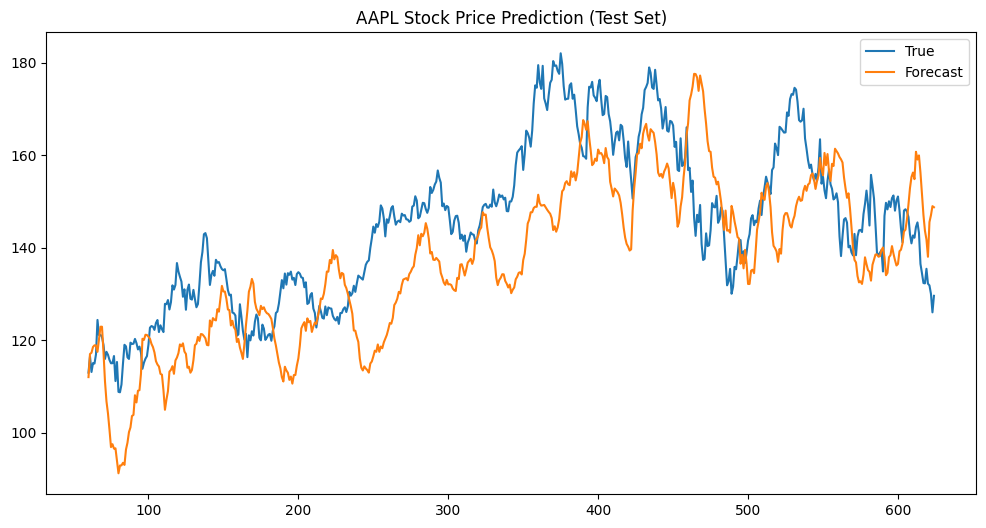

In [ ]:
# Evaluate the model on the test set
model.eval()
with torch.no_grad():
    forecast = model(X_test_tensor, torch.zeros_like(X_test_tensor), torch.zeros_like(X_test_tensor), None)

# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(range(len(test_data))[n_time_in:n_time_in + len(y_test)], y_test[:, -1], label='True')
plt.plot(range(len(test_data))[n_time_in:n_time_in + len(forecast)], forecast[:, -1], label='Forecast')
plt.legend()
plt.title(f'{ticker} Stock Price Prediction (Test Set)')
plt.show()


# Error

## MAE

In [ ]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for the test set
mae = mean_absolute_error(y_test[:, -1], forecast[:, -1])
print(f'Mean Absolute Error (MAE): {mae}')


Mean Absolute Error (MAE): 12.430132557016558


## MSE

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate MSE for the test set
mse = mean_squared_error(y_test[:, -1], forecast[:, -1])
print(f'Mean Squared Error (MSE): {mse}')


Mean Squared Error (MSE): 219.93292405441974


## RMSE

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate RMSE for the test set
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 14.830135672151478


## Error Area

Total Area of Difference (Error Area): 7023.0248947143555


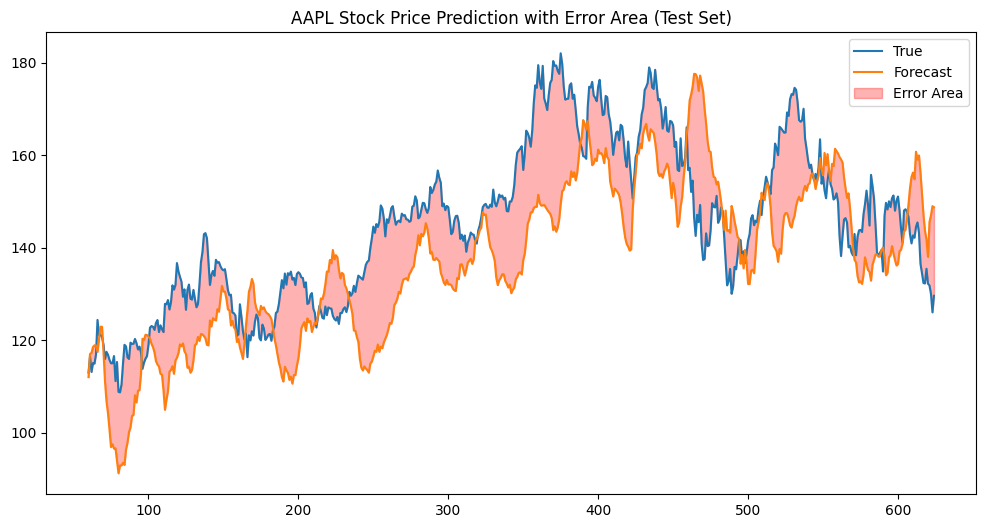

In [ ]:
# Convert the forecast tensor to a NumPy array
forecast_np = forecast.numpy()

# Calculate the absolute difference between true and forecasted values
error_area = np.sum(np.abs(y_test[:, -1] - forecast_np[:, -1]))
print(f'Total Area of Difference (Error Area): {error_area}')

# Plotting the error area
plt.figure(figsize=(12, 6))
plt.plot(range(len(test_data))[n_time_in:n_time_in + len(y_test)], y_test[:, -1], label='True')
plt.plot(range(len(test_data))[n_time_in:n_time_in + len(forecast)], forecast_np[:, -1], label='Forecast')

# Fill the area of difference
plt.fill_between(range(len(test_data))[n_time_in:n_time_in + len(forecast_np)],
                 y_test[:, -1], forecast_np[:, -1], color='red', alpha=0.3, label='Error Area')

plt.legend()
plt.title(f'{ticker} Stock Price Prediction with Error Area (Test Set)')
plt.show()


## MAPE(Mean Absolute Percentage Error)

In [ ]:
# Convert the forecast tensor to a NumPy array
forecast_np = forecast.numpy()

# Define the MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    # To avoid division by zero, we add a small epsilon where y_true is zero
    epsilon = np.finfo(np.float32).eps
    y_true = np.where(y_true == 0, epsilon, y_true)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate MAPE for the test set
mape = mean_absolute_percentage_error(y_test[:, -1], forecast_np[:, -1])
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')


Mean Absolute Percentage Error (MAPE): 8.50%
